<a href="https://colab.research.google.com/github/vitorwogel/MVP---Engenharia-de-Dados/blob/main/MVP_Engenharia_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline de Dados para Monitoramento de Despesas Públicas: Análise do Governo Federal no 1º Trimestre de 2025
Este trabalho tem por objetivo explorar e analisar os gastos governamentais de despesas púlibcas disponíveis no [portal da transparência](https://portaldatransparencia.gov.br/download-de-dados/despesas-execucao) com o intuito de responder às seguintes perguntas:

* Quais são os setores mais onerados pelo governo federal no período? O que isso revela sobre as prioridades do governo?
* Entre os órgãos que mais gastaram, para quais setores foram direcionadas essas despesas?
*   Qual órgão público foi responsável pelo maior volume de despesas no período analisado?
*   Como se distribui a alocação de recursos por cada órgão?
*   Quais órgãos são os principais financiadores dos setores mais custosos?
*   O governo está gastando mais ou gastando menos com o decorrer do tempo?

Para isso iremos utilizar de um Pipeline de dados, que faz um ETL completo desde o download dos arquivos no site origem, passando por transformações de tratamento dos dados até serem armazenados em um Data Lake. A partir daí existe um processo de carga que transfere os dados do Data Lake para o Data Warehouse, onde é estruturado o esquema estrela para as tabelas.

Após a organização das tabelas e os processos de transformação entre o conjunto *staging* (dados crus) e o *trusted* (esquema estrela montado e dados limpos) são criadas *views* no dataset *analytics* para que seja possível enfim analisar os dados e responder às perguntas.



# Coleta de dados
Nesta seção será mostrado como foi realizada a coleta dos dados para o desenvolimento do trabalho.

Os dados sobre despesas públicas foram baixados gratuitamente em formato CSV no site do [portal da transparência](https://portaldatransparencia.gov.br/) do governo federal.

Foram escolhidas 3 tabelas que representam o primeiro trimestre do ano de 2025.

Por conseguinte, os dados ainda brutos foram carregados para o ambiente de nuvem Google Cloud Platform, mais precisamente para o serviço de armazenamento Cloud Storage, onde é possível armazenar dados de qualquer tipo de maneira não estruturada através de um *bucket*.

A partir de agora passaremos a referenciar este bucket como *Data Lake*.

**Conectando aos servicos do GCP**

In [ ]:
from google.colab import auth
auth.authenticate_user()

# Configurar o projeto GCP
project_id = "dados-governamentais"
!gcloud config set project {project_id}


Updated property [core/project].


**Extraindo dados do site Portal da Transparencia**

Abaixo está o processo automatizado de extração dos dados do portal.

In [ ]:
import requests, zipfile, io

for i in range(1, 4):
    url = f'https://portaldatransparencia.gov.br/download-de-dados/despesas-execucao/20250{i}'
    file_name = f'20250{i}_Despesas.csv'

    r = requests.get(url)
    if r.ok:
        with zipfile.ZipFile(io.BytesIO(r.content)) as z, z.open(file_name) as f_in, open(file_name, "wb") as f_out:
            f_out.write(f_in.read())
        print(f"✅ '{file_name}' salvo com sucesso.")
    else:
        print(f"❌ Erro no download: {r.status_code}")


✅ '202501_Despesas.csv' salvo com sucesso.
✅ '202502_Despesas.csv' salvo com sucesso.
✅ '202503_Despesas.csv' salvo com sucesso.


# Transformação

Algumas colunas possuem dados em codificação de caracteres incorreta, o que impossibilita a ingestão direta dos nossos dados no Big Query (nosso *Data Warehouse* para este projeto).

**Ajuste da codificação dos caracteres para o padrão UTF-8**

In [ ]:
import chardet

file_paths = [
    "202501_Despesas.csv",
    "202502_Despesas.csv",
    "202503_Despesas.csv"
]

for path in file_paths:
    with open(path, "rb") as f:
        result = chardet.detect(f.read(10000))
    encoding_detectado = result['encoding']
    print(f"{path}: codificação detectada -> {encoding_detectado}")

    with open(path, "r", encoding=encoding_detectado) as f_in:
        content = f_in.read()
    with open(path, "w", encoding="utf-8") as f_out:
        f_out.write(content)

print("✅ Todos os arquivos convertidos para UTF-8.")


202501_Despesas.csv: codificação detectada -> ISO-8859-1
202502_Despesas.csv: codificação detectada -> ISO-8859-1
202503_Despesas.csv: codificação detectada -> ISO-8859-1
✅ Todos os arquivos convertidos para UTF-8.


**Editar nome de colunas antes de carregar no Big Query.**



Um dos desafios deste trabalho foi em relação a valores de ponto flutuante (números decimais), por estarem separados por vírgula ao invés de ponto ao chegar no BigQuery a vírgula estava sendo ignorada e o valor era considerado do tipo inteiro.

Para corrigir este problema foi passado o parâmetro

```
decimal=','
```

à função *read_csv* do pandas.



In [ ]:
import pandas as pd

cont = 1

while cont <= 3:
  # Abrir ignorando erros
  df = pd.read_csv(
      f"20250{cont}_Despesas.csv",
      encoding="utf-8",
      delimiter=";",
      on_bad_lines="skip",
      decimal=','
  )

  # Corrigir os nomes das colunas
  df.columns = [
      col.lower()
      .replace(" ", "_")
      .replace("(", "")
      .replace(")", "")
      .replace("ã", "a")
      .replace("ç", "c")
      .replace("é", "e")
      .replace("ó", "o")
      .replace("ô", "o")
      .replace("ê", "e")
      .replace("í", "i")
      .replace("ú", "u")
      .replace("á", "a")
      .replace("ó", "o")
      .replace("â", "a")
      .replace("º", "")
      .replace("°", "")
      .replace("´", "")
      .replace("`", "")
      .replace("'", "")
      .replace("r$", "rs")
      for col in df.columns
  ]

  # Reexportar corrigindo para UTF-8 e com separador padrão
  df.to_csv(f"despesas-{cont}.csv", index=False, encoding="utf-8")

  print(f"Tabela 'despesas-{cont}.csv carregada ✅")

  cont += 1

Tabela 'despesas-1.csv carregada ✅
Tabela 'despesas-2.csv carregada ✅
Tabela 'despesas-3.csv carregada ✅


# Carga

**Upload das tabelas codificadas para o bucket**

In [ ]:
bucket_name = "despesas-publicas"
file_paths = ["despesas-1.csv", "despesas-2.csv", "despesas-3.csv"]

for file in file_paths:
    !gsutil cp {file} gs://{bucket_name}/


Copying file://despesas-1.csv [Content-Type=text/csv]...
- [1 files][ 35.4 MiB/ 35.4 MiB]                                                
Operation completed over 1 objects/35.4 MiB.                                     
Copying file://despesas-2.csv [Content-Type=text/csv]...
- [1 files][ 40.1 MiB/ 40.1 MiB]                                                
Operation completed over 1 objects/40.1 MiB.                                     
Copying file://despesas-3.csv [Content-Type=text/csv]...
- [1 files][ 41.4 MiB/ 41.4 MiB]                                                
Operation completed over 1 objects/41.4 MiB.                                     


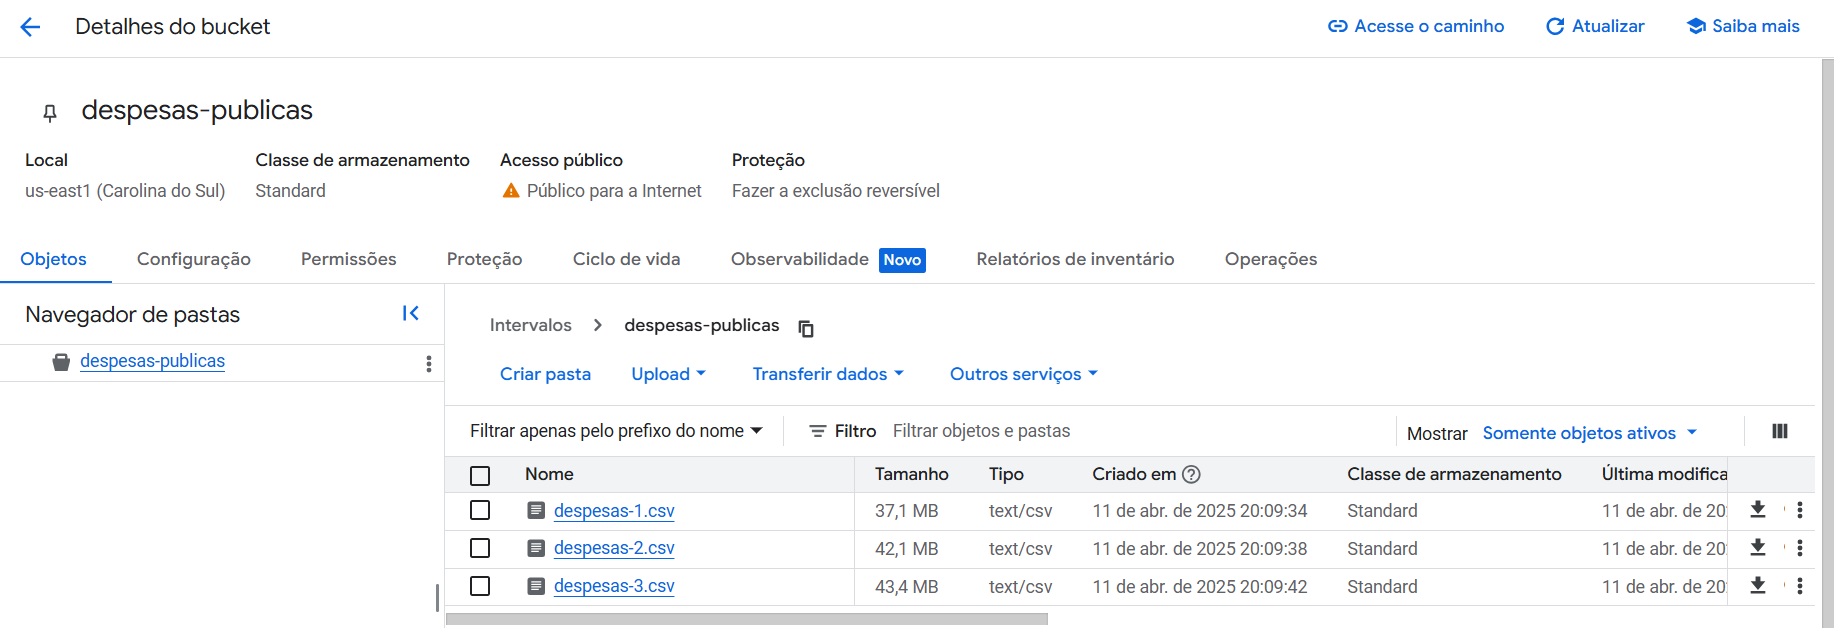

In [ ]:
from IPython.display import display, Image

display(Image('https://raw.githubusercontent.com/vitorwogel/MVP---Engenharia-de-Dados/main/images/bucket.png'))

# Evidência Data Lake povoado:

Agora que as tabelas já estão disponíveis no Data Lake, vamos transferi-las para o Data Warehouse, onde temos 3 conjuntos de dados distintos para as diferentes fases do projeto de ETL:


*   **Staging**: dados brutos, vindos do Data Lake.
*   **Trusted**: dados tratados e agrupados, com tabelas fato e dimensão.
*   **Analytics**: dados otimizados para consulta, com vizualizações específicas.



**Transferência de dados Bucket GCS -> Big Query**

Os parâmetros da função LoadJobConfig da biblioteca do BigQuery nos indicam que o arquivo é de formato CSV, que vamos pular a primeira linha (nomes das colunas), que o esquema vai ser detectado automaticamente e por fim, mas não menos importante o *WriteDisposition.WRITE_TRUNCATE* indica que vamos sobrescrever a tabela existente, se já existir, ao invés de duplicar as linhas como é feito por padrão.


In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

# Lista de tabelas e arquivos correspondentes
tables = {
    "despesas1": f"gs://{bucket_name}/despesas-1.csv",
    "despesas2": f"gs://{bucket_name}/despesas-2.csv",
    "despesas3": f"gs://{bucket_name}/despesas-3.csv"
}

for table_name, file_path in tables.items():
    table_id = f"{project_id}.staging.{table_name}"

    job_config = bigquery.LoadJobConfig(
        source_format=bigquery.SourceFormat.CSV,
        skip_leading_rows=1,
        autodetect=True,
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
    )

    load_job = client.load_table_from_uri(
        file_path, table_id, job_config=job_config
    )
    load_job.result()  # Espera a carga terminar
    print(f"✅ Tabela {table_name} carregada com sucesso!")


✅ Tabela despesas1 carregada com sucesso!
✅ Tabela despesas2 carregada com sucesso!
✅ Tabela despesas3 carregada com sucesso!


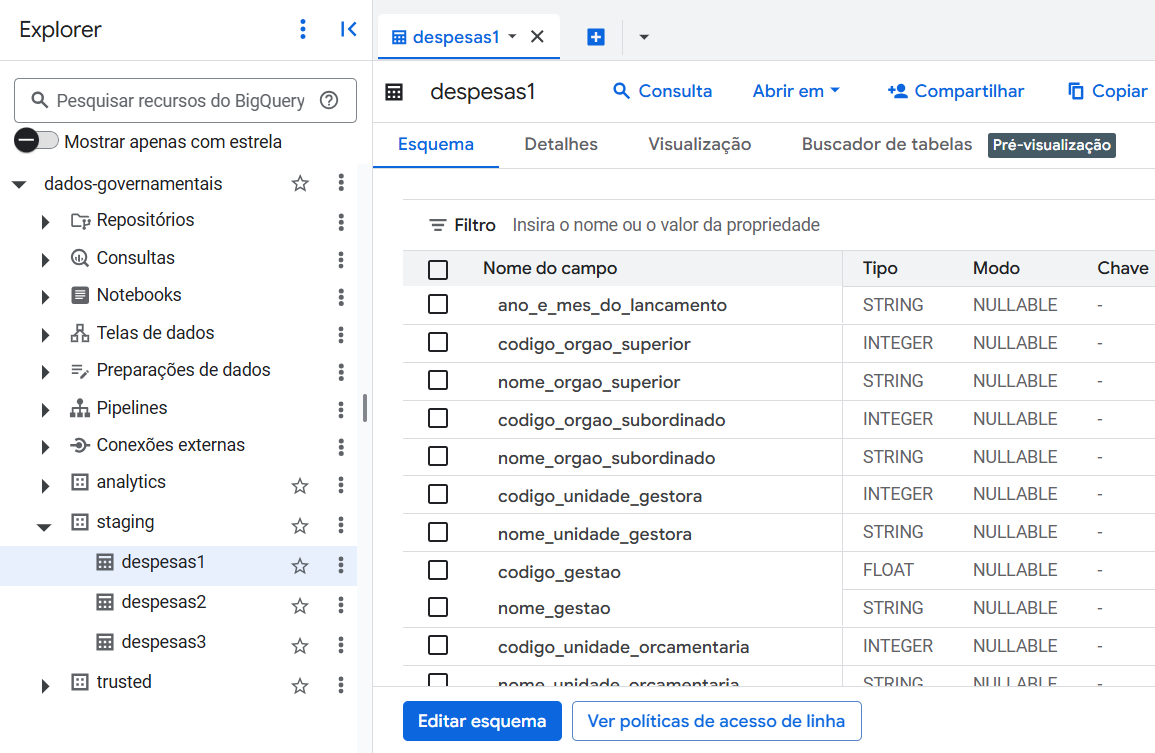

In [ ]:
from IPython.display import display, Image

display(Image('https://raw.githubusercontent.com/vitorwogel/MVP---Engenharia-de-Dados/main/images/staging.png'))

# Evidência conjunto staging no Data Warehouse povoado:

# Tratamento de dados

**Dados ausentes ou inválidos**

Fazendo uma pequena exploração inicial nos dados já foi possível detectar que as tabelas 1 e 2 contam com dados ausentes ou inválidos, enquanto a tabela 3 não possui essa deficiência.

Inicialmente a abordagem foi deletar as colunas que possuissem valores ausentes para os campos de 'codigo_unidade_gestora', 'codigo_orgao_superior' e 'codigo_orgao_subordinado', no entanto, notou-se que apesar desses valores não estarem presentes em algumas tuplas, ainda sim estas poderiam ser relevantes para análise.

A opção foi de seguir com valores antes considerados inválidos e para valores nulos iremos preencher código com -1 e nome "Desconhecido".

**Tratamento de dados utilizando a biblioteca pandas**

Neste trecho vamos dispor da biblioteca pandas para analisar melhor nossas tabelas no quesito da qualidade dos dados.

In [ ]:
import pandas as pd

df = pd.DataFrame()

for i in range(3):
    # Define a query para buscar os dados da tabela
    query = f"""
        SELECT *
        FROM `dados-governamentais.staging.despesas{i+1}`
    """

    # Executa a query e traz os dados como DataFrame
    df_raw = client.query(query).to_dataframe()

    # Concatena os dados ao DataFrame final
    df = pd.concat([df, df_raw], ignore_index=True)

# Visualiza os dados
df.head()

,ano_e_mes_do_lancamento,codigo_orgao_superior,nome_orgao_superior,codigo_orgao_subordinado,nome_orgao_subordinado,codigo_unidade_gestora,nome_unidade_gestora,codigo_gestao,nome_gestao,codigo_unidade_orcamentaria,...,codigo_elemento_de_despesa,nome_elemento_de_despesa,codigo_modalidade_da_despesa,modalidade_da_despesa,valor_empenhado_rs,valor_liquidado_rs,valor_pago_rs,valor_restos_a_pagar_inscritos_rs,valor_restos_a_pagar_cancelado_rs,valor_restos_a_pagar_pagos_rs
0,2025/01,-1,Sem informação,-3,None,-3,Inválido,36201.0,CONSELHO NAC.DE DESENV.CIENTIFICO TECNOLOGICO,24201,...,92,Despesas de Exercícios Anteriores,90,Aplicações Diretas,0.0,0.0,0.0,-1508.31,0.0,0.0
1,2025/01,-1,Sem informação,-3,None,-3,Inválido,36201.0,CONSELHO NAC.DE DESENV.CIENTIFICO TECNOLOGICO,24201,...,18,Auxílio Financeiro a Estudantes,90,Aplicações Diretas,0.0,0.0,0.0,-2989796.29,0.0,0.0
2,2025/01,-1,Sem informação,-3,None,-3,Inválido,36201.0,CONSELHO NAC.DE DESENV.CIENTIFICO TECNOLOGICO,24201,...,18,Auxílio Financeiro a Estudantes,90,Aplicações Diretas,0.0,0.0,0.0,-22963.20,0.0,0.0
3,2025/01,-1,Sem informação,-3,None,-3,Inválido,36201.0,CONSELHO NAC.DE DESENV.CIENTIFICO TECNOLOGICO,24201,...,92,Despesas de Exercícios Anteriores,90,Aplicações Diretas,0.0,0.0,0.0,-858.93,0.0,0.0
4,2025/01,-1,Sem informação,-3,None,-3,Inválido,36201.0,CONSELHO NAC.DE DESENV.CIENTIFICO TECNOLOGICO,24201,...,39,Outros Serviços de Terceiros - Pessoa Juríd,90,Aplicações Diretas,0.0,0.0,0.0,-30245.40,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162008 entries, 0 to 162007
Data columns (total 47 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ano_e_mes_do_lancamento             162008 non-null  object 
 1   codigo_orgao_superior               162008 non-null  Int64  
 2   nome_orgao_superior                 162008 non-null  object 
 3   codigo_orgao_subordinado            162008 non-null  Int64  
 4   nome_orgao_subordinado              160395 non-null  object 
 5   codigo_unidade_gestora              162008 non-null  Int64  
 6   nome_unidade_gestora                162008 non-null  object 
 7   codigo_gestao                       161436 non-null  float64
 8   nome_gestao                         161436 non-null  object 
 9   codigo_unidade_orcamentaria         162008 non-null  Int64  
 10  nome_unidade_orcamentaria           162008 non-null  object 
 11  codigo_funcao             

**Drop de algumas colunas**

Para nossa análise não vamos utilizar todas as 47 colunas presentes no dataset, por isso removi aquelas que seriam menos relevantes para análise com base nas perguntas de negócio elencadas.

In [ ]:
# Lista de colunas que podem ser descartadas com base na análise
columns_to_remove = [
    'codigo_plano_orcamentario', 'plano_orcamentario',
    'codigo_programa_governo', 'nome_programa_governo', 'codigo_subtitulo', 'nome_subtitulo',
    'codigo_localizador', 'nome_localizador', 'sigla_localizador',
    'descricao_complementar_localizador', 'codigo_autor_emenda', 'nome_autor_emenda',
    'codigo_categoria_economica', 'nome_categoria_economica', 'codigo_elemento_de_despesa', 'nome_elemento_de_despesa',
    'codigo_modalidade_da_despesa', 'modalidade_da_despesa', 'uf', 'municipio'
]

# Remover as colunas do dataframe
data_cleaned = df.drop(columns=columns_to_remove)

# Exibir as primeiras linhas para conferência
data_cleaned.head()

,ano_e_mes_do_lancamento,codigo_orgao_superior,nome_orgao_superior,codigo_orgao_subordinado,nome_orgao_subordinado,codigo_unidade_gestora,nome_unidade_gestora,codigo_gestao,nome_gestao,codigo_unidade_orcamentaria,...,codigo_acao,nome_acao,codigo_grupo_de_despesa,nome_grupo_de_despesa,valor_empenhado_rs,valor_liquidado_rs,valor_pago_rs,valor_restos_a_pagar_inscritos_rs,valor_restos_a_pagar_cancelado_rs,valor_restos_a_pagar_pagos_rs
0,2025/01,-1,Sem informação,-3,None,-3,Inválido,36201.0,CONSELHO NAC.DE DESENV.CIENTIFICO TECNOLOGICO,24201,...,00LV,"FORMACAO, CAPACITACAO E FIXACAO DE RECURSOS HU...",3,Outras Despesas Correntes,0.0,0.0,0.0,-1508.31,0.0,0.0
1,2025/01,-1,Sem informação,-3,None,-3,Inválido,36201.0,CONSELHO NAC.DE DESENV.CIENTIFICO TECNOLOGICO,24201,...,00LV,"FORMACAO, CAPACITACAO E FIXACAO DE RECURSOS HU...",3,Outras Despesas Correntes,0.0,0.0,0.0,-2989796.29,0.0,0.0
2,2025/01,-1,Sem informação,-3,None,-3,Inválido,36201.0,CONSELHO NAC.DE DESENV.CIENTIFICO TECNOLOGICO,24201,...,00LV,"FORMACAO, CAPACITACAO E FIXACAO DE RECURSOS HU...",3,Outras Despesas Correntes,0.0,0.0,0.0,-22963.20,0.0,0.0
3,2025/01,-1,Sem informação,-3,None,-3,Inválido,36201.0,CONSELHO NAC.DE DESENV.CIENTIFICO TECNOLOGICO,24201,...,00LV,"FORMACAO, CAPACITACAO E FIXACAO DE RECURSOS HU...",3,Outras Despesas Correntes,0.0,0.0,0.0,-858.93,0.0,0.0
4,2025/01,-1,Sem informação,-3,None,-3,Inválido,36201.0,CONSELHO NAC.DE DESENV.CIENTIFICO TECNOLOGICO,24201,...,00LV,"FORMACAO, CAPACITACAO E FIXACAO DE RECURSOS HU...",3,Outras Despesas Correntes,0.0,0.0,0.0,-30245.40,0.0,0.0


In [ ]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162008 entries, 0 to 162007
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ano_e_mes_do_lancamento            162008 non-null  object 
 1   codigo_orgao_superior              162008 non-null  Int64  
 2   nome_orgao_superior                162008 non-null  object 
 3   codigo_orgao_subordinado           162008 non-null  Int64  
 4   nome_orgao_subordinado             160395 non-null  object 
 5   codigo_unidade_gestora             162008 non-null  Int64  
 6   nome_unidade_gestora               162008 non-null  object 
 7   codigo_gestao                      161436 non-null  float64
 8   nome_gestao                        161436 non-null  object 
 9   codigo_unidade_orcamentaria        162008 non-null  Int64  
 10  nome_unidade_orcamentaria          162008 non-null  object 
 11  codigo_funcao                      1620

**Tratamento de valores nulos**

In [ ]:
data_cleaned['codigo_gestao'] = data_cleaned['codigo_gestao'].fillna(-1)
data_cleaned['nome_gestao'] = data_cleaned['nome_gestao'].fillna("Desconhecido")
data_cleaned['nome_orgao_subordinado'] = data_cleaned['nome_orgao_subordinado'].fillna("Desconhecido")

In [ ]:
print(data_cleaned.isnull().sum())

ano_e_mes_do_lancamento              0
codigo_orgao_superior                0
nome_orgao_superior                  0
codigo_orgao_subordinado             0
nome_orgao_subordinado               0
codigo_unidade_gestora               0
nome_unidade_gestora                 0
codigo_gestao                        0
nome_gestao                          0
codigo_unidade_orcamentaria          0
nome_unidade_orcamentaria            0
codigo_funcao                        0
nome_funcao                          0
codigo_subfucao                      0
nome_subfuncao                       0
codigo_programa_orcamentario         0
nome_programa_orcamentario           0
codigo_acao                          0
nome_acao                            0
codigo_grupo_de_despesa              0
nome_grupo_de_despesa                0
valor_empenhado_rs                   0
valor_liquidado_rs                   0
valor_pago_rs                        0
valor_restos_a_pagar_inscritos_rs    0
valor_restos_a_pagar_canc

**Padronizar valores não informados**

Em uma análise inicial no Big Query, notou-se que alguns códigos de colunas diferentes tinham padrões diferentes para valores ausentes (como -3 ou -1).

Optou-se por substituir todos os valores negativos por -1, por padronização.

In [ ]:
cols_codigos = [
    'codigo_orgao_superior',
    'codigo_orgao_subordinado',
    'codigo_unidade_gestora',
    'codigo_gestao',
    'codigo_unidade_orcamentaria',
    'codigo_funcao',
    'codigo_subfucao',
    'codigo_programa_orcamentario',
    'codigo_grupo_de_despesa'
]

for col in cols_codigos:
    data_cleaned[col] = data_cleaned[col].apply(lambda x: -1 if x < 0 else x)


O mesmo aconteceu para valores categóricos, por isso todos foram padronizados para "Desconhecido" (ao invés de variações como "Sem Informação ou Inválido).

In [ ]:
mapeamentos = [
    ('codigo_orgao_superior', 'nome_orgao_superior'),
    ('codigo_orgao_subordinado', 'nome_orgao_subordinado'),
    ('codigo_unidade_gestora', 'nome_unidade_gestora'),
    ('codigo_gestao', 'nome_gestao'),
    ('codigo_unidade_orcamentaria', 'nome_unidade_orcamentaria'),
    ('codigo_funcao', 'nome_funcao'),
    ('codigo_subfucao', 'nome_subfuncao'),
    ('codigo_programa_orcamentario', 'nome_programa_orcamentario'),
    ('codigo_grupo_de_despesa', 'nome_grupo_de_despesa'),
]

for codigo_col, nome_col in mapeamentos:
    data_cleaned.loc[data_cleaned[codigo_col] < 0, nome_col] = 'Desconhecido'


**Checar valores duplicados**

As tuplas duplicadas no dataset foram identificadas e tratadas conforme o código abaixo.

In [ ]:
print(data_cleaned.duplicated(subset=data_cleaned.columns.drop("ano_e_mes_do_lancamento")).sum())

data_cleaned = data_cleaned.drop_duplicates(subset=data_cleaned.columns.drop("ano_e_mes_do_lancamento"))

2972


# Esquema estrela

Nesta seção vamos definir a arquitetura estrela em nosso Data Warehouse.

Para isso, o conjunto de dados Trusted será populado com uma tabela fato, contendo todas as colunas e métricas, e tabelas dimensão, granularizadas com código (PK) e o atributo de interesse.

**Exportando a tabela fato para o dataset *trusted***

In [ ]:
from pandas_gbq import to_gbq

dataset_id = 'trusted'
table_name = 'tabela_fato'

# Exporta o DataFrame para o BigQuery
to_gbq(data_cleaned, destination_table=f'{dataset_id}.{table_name}', project_id=project_id, if_exists='replace')


100%|██████████| 1/1 [00:00<00:00, 4424.37it/s]


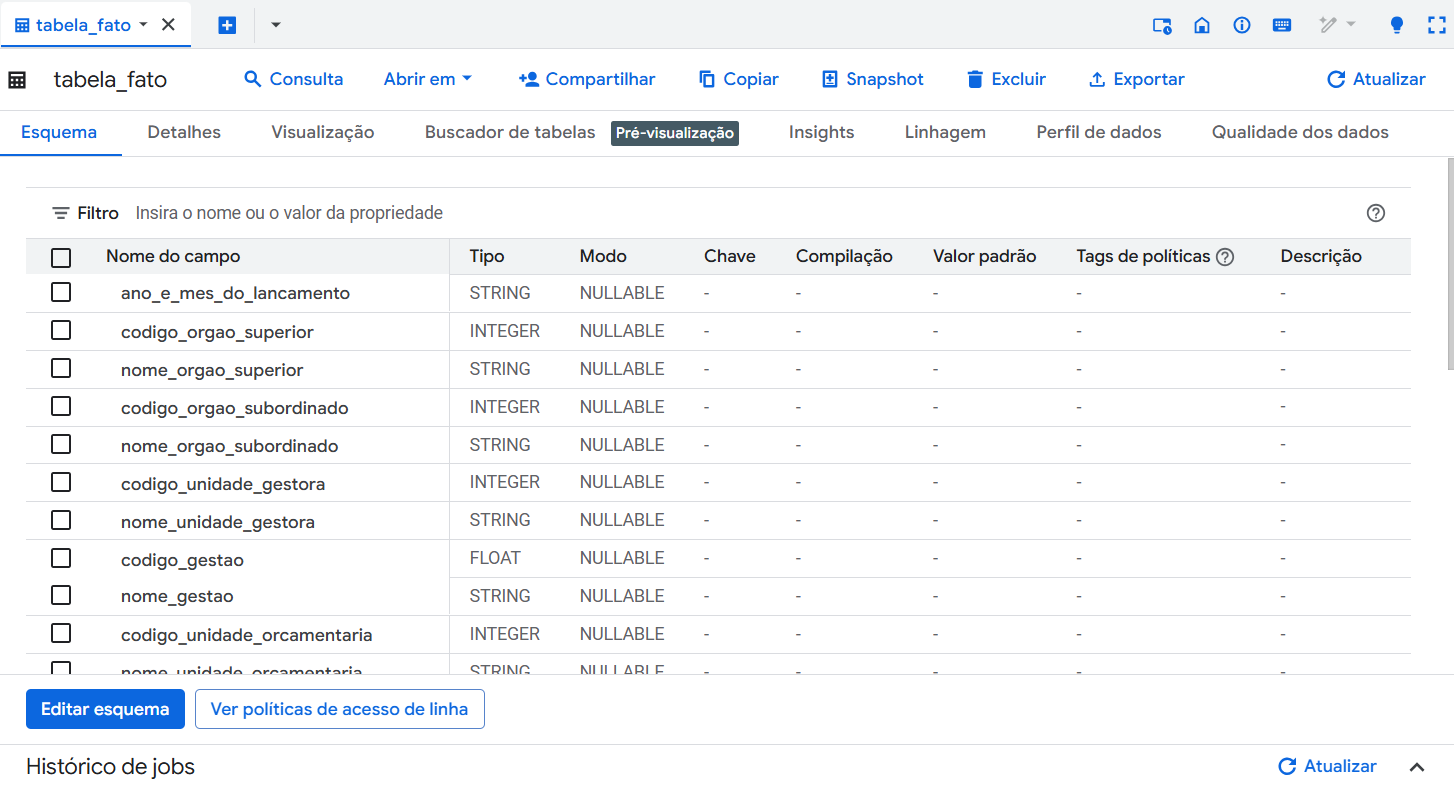

In [ ]:
from IPython.display import display, Image

display(Image('https://raw.githubusercontent.com/vitorwogel/MVP---Engenharia-de-Dados/main/images/fato.png'))

# Evidência tabela fato no Data Warehouse povoado:

**Criando tabelas dimensão**

In [ ]:
dim_orgao_superior = data_cleaned[["codigo_orgao_superior", "nome_orgao_superior"]]
dim_orgao_subordinado = data_cleaned[["codigo_orgao_subordinado", "nome_orgao_subordinado"]]
dim_gestao = data_cleaned[["codigo_gestao", "nome_gestao"]]
dim_unidade_gestora = data_cleaned[["codigo_unidade_gestora", "nome_unidade_gestora"]]
dim_programa_orcamentario = data_cleaned[["codigo_programa_orcamentario", "nome_programa_orcamentario"]]
dim_unidade_orcamentaria = data_cleaned[["codigo_unidade_orcamentaria", "nome_unidade_orcamentaria"]]
dim_funcao = data_cleaned[["codigo_funcao", "nome_funcao"]]
dim_subfuncao = data_cleaned[["codigo_subfucao", "nome_subfuncao"]]
dim_acao = data_cleaned[["codigo_acao","nome_acao"]]
dim_despesa = data_cleaned[["codigo_grupo_de_despesa","nome_grupo_de_despesa"]]

mapped_dims = {
    "dim_orgao_superior": dim_orgao_superior,
    "dim_orgao_subordinado": dim_orgao_subordinado,
    "dim_gestao": dim_gestao,
    "dim_unidade_gestora": dim_unidade_gestora,
    "dim_programa_orcamentario": dim_programa_orcamentario,
    "dim_unidade_orcamentaria": dim_unidade_orcamentaria,
    "dim_funcao": dim_funcao,
    "dim_subfuncao": dim_subfuncao,
    "dim_acao": dim_acao,
    "dim_despesa": dim_despesa
}

# Define os índices compostos únicos para cada dimensão
unique_keys = {
    "dim_orgao_superior": ["codigo_orgao_superior"],
    "dim_orgao_subordinado": ["codigo_orgao_subordinado"],
    "dim_gestao": ["codigo_gestao"],
    "dim_unidade_gestora": ["codigo_unidade_gestora"],
    "dim_programa_orcamentario": ["codigo_programa_orcamentario"],
    "dim_unidade_orcamentaria": ["codigo_unidade_orcamentaria"],
    "dim_funcao": ["codigo_funcao"],
    "dim_subfuncao": ["codigo_subfucao"],
    "dim_acao": ["codigo_acao"],
    "dim_despesa": ["codigo_grupo_de_despesa"]
}

# Remove duplicatas com base nas chaves
for k, v in mapped_dims.items():
    chave = unique_keys[k]
    mapped_dims[k] = v.drop_duplicates(subset=chave)

# Exporta para o BigQuery com as dimensões
for k, v in mapped_dims.items():
    to_gbq(v, destination_table=f'{dataset_id}.{k}', project_id=project_id, if_exists='replace')


100%|██████████| 1/1 [00:00<00:00, 4686.37it/s]


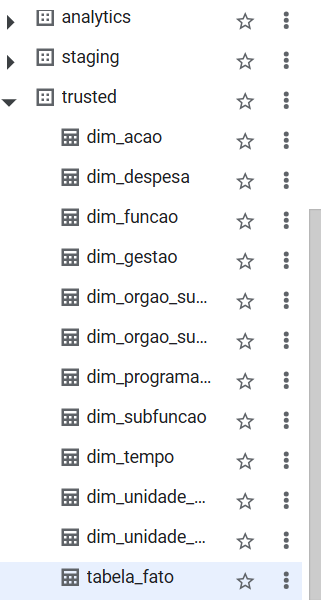

In [ ]:
from IPython.display import display, Image

display(Image('https://raw.githubusercontent.com/vitorwogel/MVP---Engenharia-de-Dados/main/images/trusted.png'))

# Evidência conjunto trusted no Data Warehouse povoado:

Vamos inserir também uma dimensão tempo que vai ser criada a partir do campo *ano_mes_lancamento* da tabela fato, criando uma coluna adicional de id incremental.



In [ ]:
query = f"""
  CREATE OR REPLACE TABLE `dados-governamentais.trusted.dim_tempo` AS
  SELECT
    ROW_NUMBER() OVER () AS id,
    ano_e_mes_do_lancamento AS ano_mes
  FROM (
    SELECT DISTINCT ano_e_mes_do_lancamento
    FROM `dados-governamentais.trusted.tabela_fato`
  )
"""

client.query(query)


QueryJob<project=dados-governamentais, location=us-east1, id=f173023e-587d-4110-a02f-1fcde9ccad69>

Devemos também adicionar o campo do código na tabela_fato, para facilitar a referência através de JOINS.

In [ ]:
query = """
  ALTER TABLE `dados-governamentais.trusted.tabela_fato`
  ADD COLUMN codigo_ano_mes INT64
"""

client.query(query)

QueryJob<project=dados-governamentais, location=us-east1, id=99a198c8-a886-44b8-8eb9-330fcee3cb10>

Atualizando os valores correspondentes na tabela fato com as informações da dimensão tempo.

In [ ]:
query = """
  UPDATE `dados-governamentais.trusted.tabela_fato` tf
  SET codigo_ano_mes = (
    SELECT dt.id
    FROM
    `dados-governamentais.trusted.dim_tempo` dt
    WHERE tf.ano_e_mes_do_lancamento = dt.ano_mes
  )
  WHERE 1=1
"""

client.query(query)

QueryJob<project=dados-governamentais, location=us-east1, id=ef2d17af-308d-4c08-994a-c9679c856c49>

# Análise de dados

Antes de começar de fato as análises que podem responder as nossas perguntas vamos popular o conjunto de dados Analytics com *views*, consultas salvas que contém dados prontos para uma análise mais especifica, utilizando ou não de *joins* entre a tabela fato e as demais dimensões do conjunto Trusted.

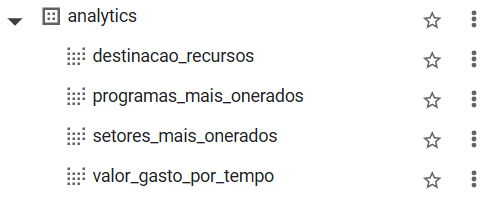

In [ ]:
from IPython.display import display, Image

display(Image('https://raw.githubusercontent.com/vitorwogel/MVP---Engenharia-de-Dados/main/images/analytics.png'))

# Evidência conjunto analytics no Data Warehouse povoado:

Vamos analisar e tentar responder algumas perguntas a partir das views criadas.

1. **Quais são os setores mais onerados pelo governo federal no período? O que isso revela sobre as prioridades do governo?**

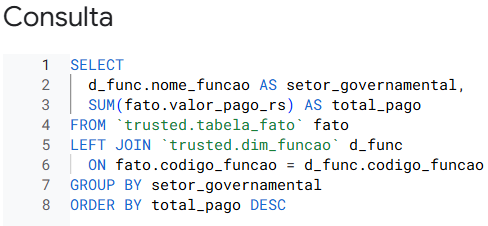

In [ ]:
from IPython.display import display, Image

display(Image('https://raw.githubusercontent.com/vitorwogel/MVP---Engenharia-de-Dados/main/images/view01.png'))

# Abaixo a consulta da view "setores_mais_onerados"

In [ ]:
import matplotlib.pyplot as plt

# Define a query para buscar os dados da tabela
query = f"""
    SELECT *
    FROM `dados-governamentais.analytics.setores_mais_onerados`
"""

# Executa a query e traz os dados como DataFrame
df_top_setores = client.query(query).to_dataframe()


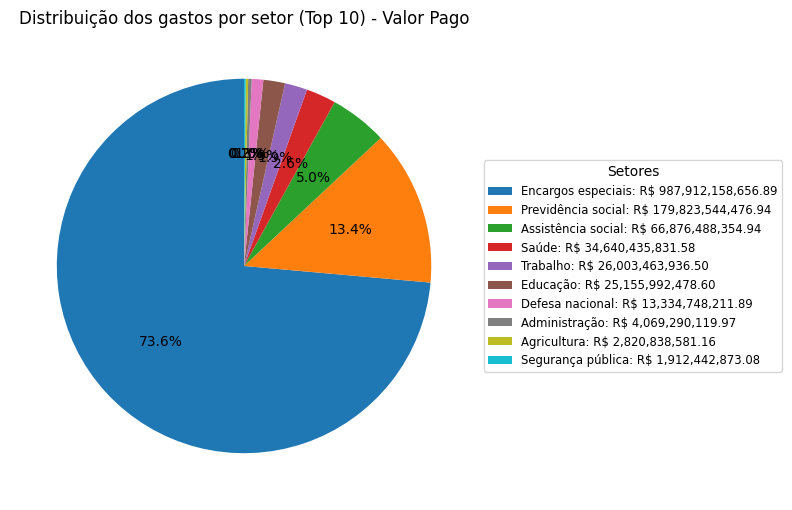

In [ ]:
# Seleciona os 10 setores que mais gastaram
top10 = df_top_setores.sort_values("total_pago", ascending=False).head(10)

# Dados para o gráfico
labels = top10["setor_governamental"]
values = top10["total_pago"]

# Formata os valores para legenda
legenda = [f"{nome}: R$ {valor:,.2f}" for nome, valor in zip(labels, values)]

# Criação do gráfico de pizza
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(values, labels=None, startangle=90, autopct='%1.1f%%')

# Adiciona legenda ao lado com os valores formatados
plt.legend(legenda, title="Setores", loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')
plt.title("Distribuição dos gastos por setor (Top 10) - Valor Pago")

plt.tight_layout()
plt.show()

**Análise:** Na figura conseguimos interpretar pelo gráfico que "Encargos especiais" se trata do setor que mais gasta dinheiro público. Nesta categoria podemos enquadrar:

841 - Refinanciamento da Dívida Interna

842 - Refinanciamento da Dívida Externa

843 - Serviço da Dívida Interna

844 - Serviço da Dívida Externa

845 - Outras Transferências

846 - Outros Encargos Especiais

847 - Transferências para a Educação Básica

É de conhecimento geral que o Brasil tem muitos problemas com excesso de gastos no governo, a partir da análise aprensetada podemos refletir sobre como o dinheiro não está indo para onde a população de fato precisa, com áreas como saúde e educação tomando uma faixa mínima do percentual, enquanto pagamento de dívidas e previdência social ocupam 87% da folha de pagamentos do governo federal.

2. **Entre os órgãos que mais gastaram, para quais setores foram direcionadas essas despesas?**

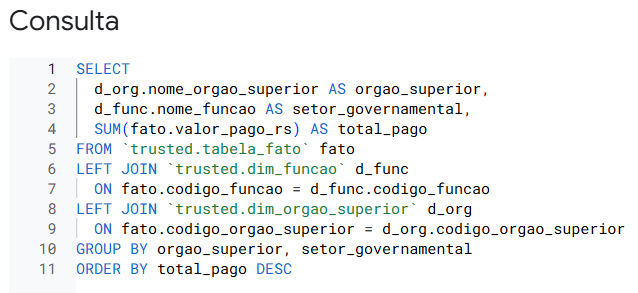

In [ ]:
from IPython.display import display, Image

display(Image('https://raw.githubusercontent.com/vitorwogel/MVP---Engenharia-de-Dados/main/images/view02.png'))

# Abaixo a consulta da view "destinacao_recursos"

In [ ]:
# Define a query para buscar os dados da tabela
query = f"""
    SELECT *
    FROM `dados-governamentais.analytics.destinacao_recursos`
"""

# Executa a query e traz os dados como DataFrame
df_top_ministerios = client.query(query).to_dataframe()

In [ ]:
# Como a view já está ordenada, basta selecionar os 10 primeiros registros
top_10 = df_top_ministerios.head(10)

import seaborn as sns

# Exibir como tabela
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Formatar os valores pagos em bilhões para melhor leitura
top_10_display = top_10.copy()
top_10_display["total_pago"] = top_10_display["total_pago"] / 1e9  # converte para bilhões
top_10_display["total_pago"] = top_10_display["total_pago"].map(lambda x: f"R$ {x:,.2f} bi")

top_10_display.reset_index(drop=True, inplace=True)
top_10_display.index += 1  # Começa do 1

top_10_display


,orgao_superior,setor_governamental,total_pago
1,Ministério da Fazenda,Encargos especiais,R$ 962.21 bi
2,Ministério da Previdência Social,Previdência social,R$ 168.53 bi
3,Ministério do Desenvolvimento e Assistência,Assistência social,R$ 42.19 bi
4,Ministério da Saúde,Saúde,R$ 34.30 bi
5,Ministério do Trabalho e Emprego,Trabalho,R$ 25.96 bi
6,Ministério da Educação,Educação,R$ 25.16 bi
7,Ministério da Previdência Social,Assistência social,R$ 24.68 bi
8,Ministério da Defesa,Defesa nacional,R$ 13.12 bi
9,Ministério de Minas e Energia,Encargos especiais,R$ 9.83 bi
10,Ministério da Integração e do Desenvolvime,Encargos especiais,R$ 6.46 bi


**Análise:** Dessa totalidade de gastos exorbitantes entre Encargos Especiais e Previdência Social, conseguimos observar que os órgãos responsáveis pela maior parte do envio do dinheiro são o Ministério da Fazenda e o Ministério da Previdência Social.

É de se ressaltar também o excesso de gastos com assistencialismo social, que supera com folga setores importantes como saúde e educação.

3. **Qual órgão público foi responsável pelo maior volume de despesas no período analisado?**

In [ ]:
orgaos = df_top_ministerios.drop("setor_governamental", axis=1)
mais_gastou = orgaos.groupby("orgao_superior")["total_pago"].sum().sort_values(ascending=False)

valor = mais_gastou.iloc[0]
orgao = mais_gastou.index[0]
result = f"{orgao} foi o órgão que mais gastou: R${valor / 1e9:,.2f} bi"
print(result)


Ministério da Fazenda foi o órgão que mais gastou: R$965.64 bi


4. **Como se distribui a alocação de recursos por cada órgão?**



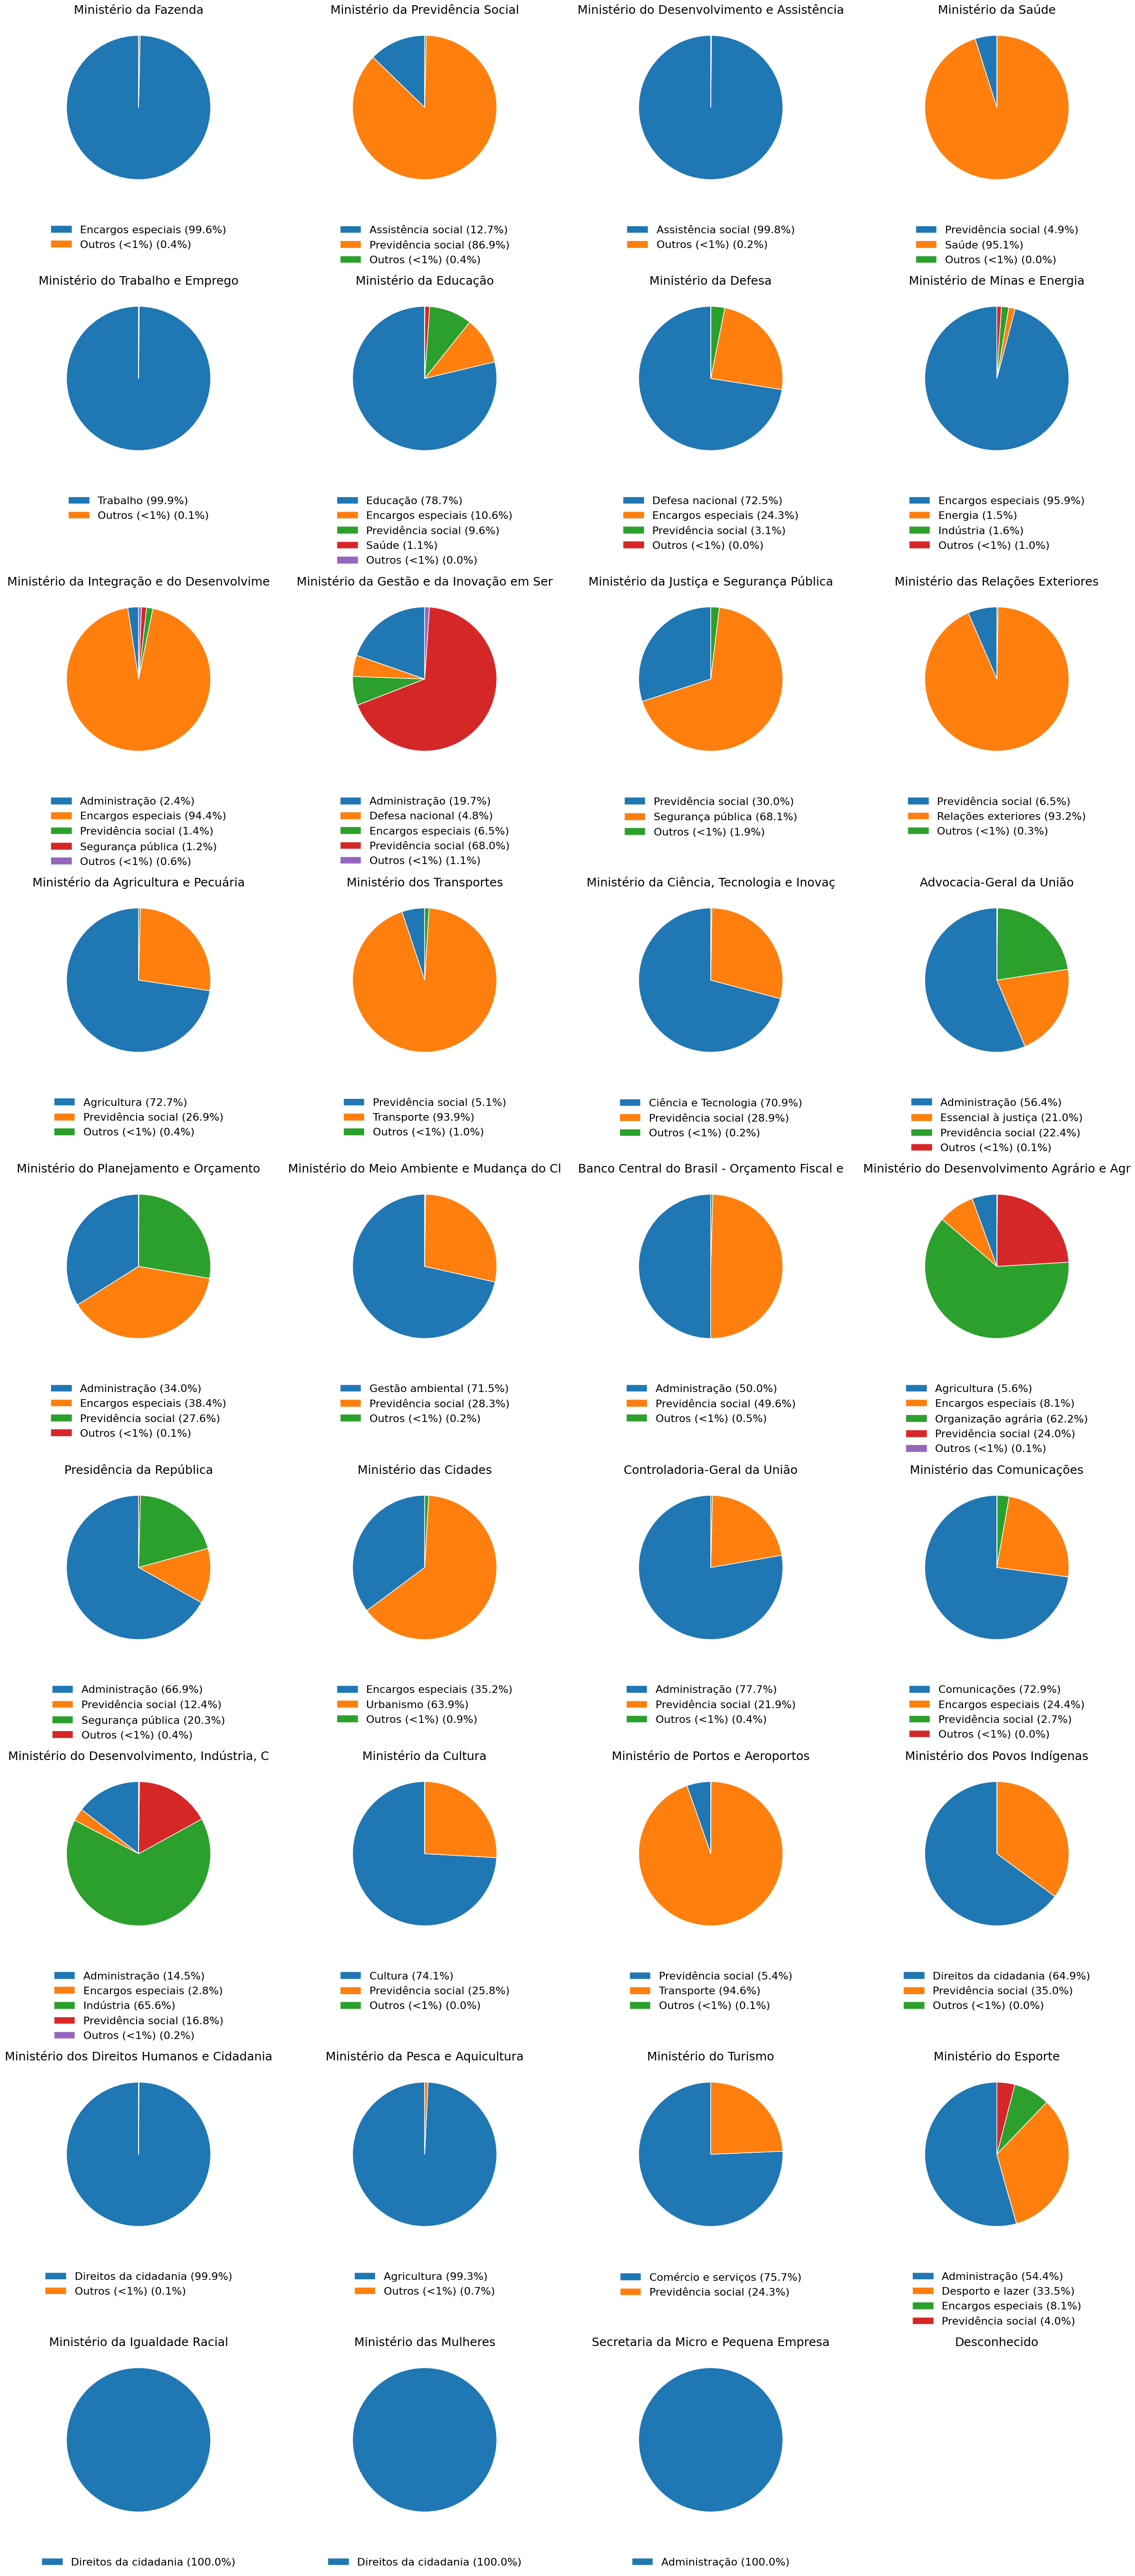

In [ ]:
import matplotlib.pyplot as plt
import math

# Captura todos os órgãos únicos na ordem do DataFrame
orgaos_unicos = df_top_ministerios["orgao_superior"].drop_duplicates().tolist()
n_orgaos = len(orgaos_unicos)

# Define layout: 4 gráficos por linha
cols = 4
rows = math.ceil(n_orgaos / cols)

fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), constrained_layout=True)
axs = axs.flatten()  # Facilita o acesso por índice

for i, orgao in enumerate(orgaos_unicos):
    ax = axs[i]
    dados_orgao = df_top_ministerios[df_top_ministerios["orgao_superior"] == orgao]
    gastos_setores = dados_orgao.groupby("setor_governamental")["total_pago"].sum()
    total = gastos_setores.sum()

    gastos_filtrados = gastos_setores[gastos_setores / total >= 0.01]
    outros = gastos_setores[gastos_setores / total < 0.01].sum()
    if outros > 0:
        gastos_filtrados["Outros (<1%)"] = outros

    labels_legenda = [f"{setor} ({valor/total*100:.1f}%)" for setor, valor in gastos_filtrados.items()]

    wedges, _ = ax.pie(
        gastos_filtrados,
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )

    ax.set_title(orgao, fontsize=18)
    ax.legend(
        wedges,
        labels_legenda,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        fontsize=16,
        frameon=False
    )

# Esconde os subplots vazios se houver
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.show()


**Análise:** A partir dos gráficos acima é possível observar que alguns ministérios concentram seus gastos em pastas específicas, como 100% da verba dos ministérios da Igualdade Racial e das Mulheres são destinados à Direitos da Cidania, enquanto outros órgãos como Advocacia Geral da União e Presidência da República possuem um portifólio mais diverso.

5. **Quais órgãos são os principais financiadores dos setores mais custosos?**






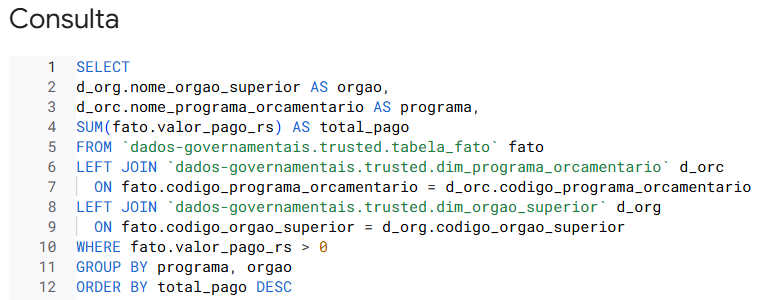

In [ ]:
from IPython.display import display, Image

display(Image('https://raw.githubusercontent.com/vitorwogel/MVP---Engenharia-de-Dados/main/images/view03.png'))

# Abaixo a consulta da view "programas_mais_onerados"

In [ ]:
# Define a query para buscar os dados da tabela
query = f"""
    SELECT *
    FROM `dados-governamentais.analytics.programas_mais_onerados`
"""

# Executa a query e traz os dados como DataFrame
df_top_programas = client.query(query).to_dataframe()

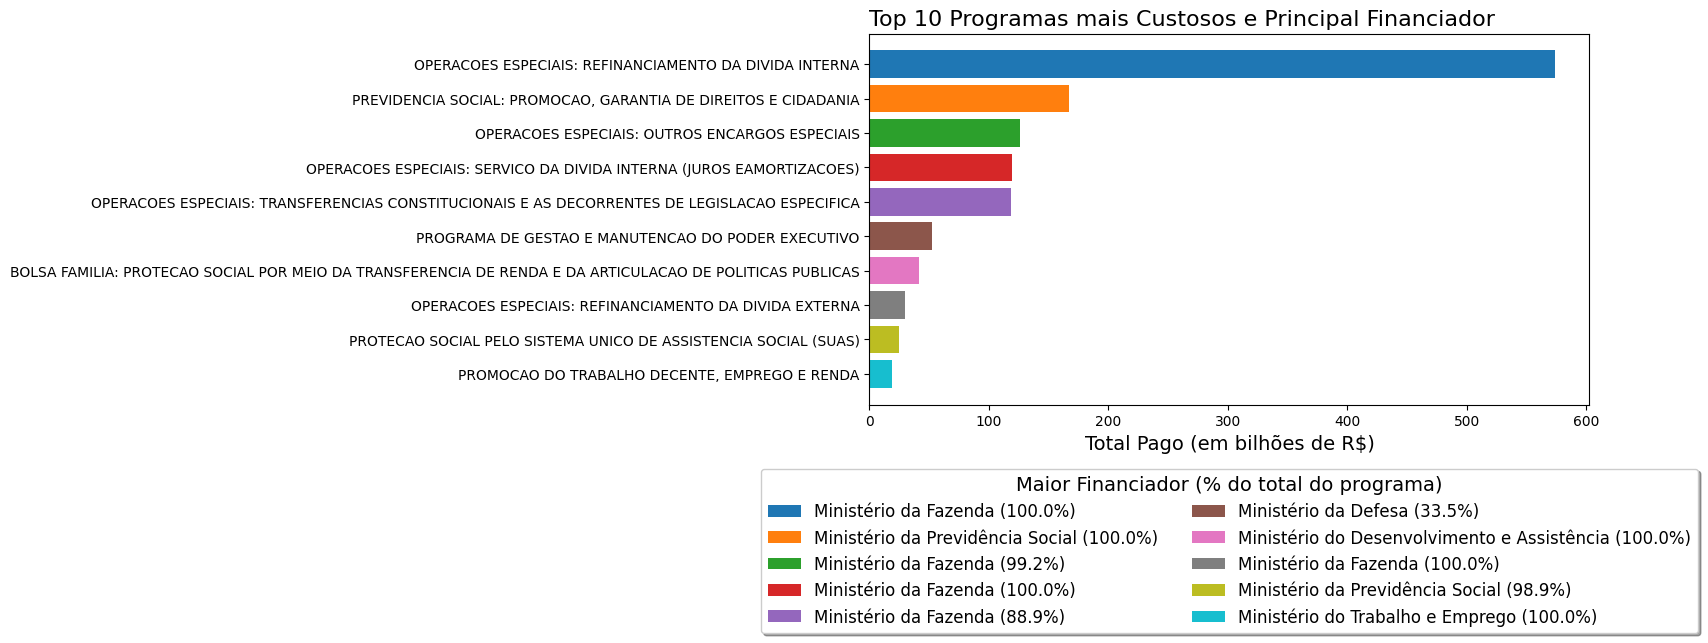

In [ ]:
import itertools

# Agrupar por programa para obter o total pago por programa
totais_programas = df_top_programas.groupby("programa")["total_pago"].sum().reset_index()

# Para cada programa, encontrar o órgão que mais investiu e a porcentagem do total
maior_investidor = (
    df_top_programas.groupby(["programa", "orgao"])["total_pago"]
    .sum()
    .reset_index()
    .sort_values(["programa", "total_pago"], ascending=[True, False])
)

# Selecionar o órgão que mais investiu em cada programa
maiores_org_por_programa = maior_investidor.groupby("programa").first().reset_index()

# Juntar com os totais para calcular a porcentagem
df_completo = pd.merge(totais_programas, maiores_org_por_programa, on="programa", suffixes=("_total", "_orgao"))
df_completo["porcentagem"] = (df_completo["total_pago_orgao"] / df_completo["total_pago_total"]) * 100

# Ordenar pelos programas que mais receberam no total
df_top10 = df_completo.sort_values(by="total_pago_total", ascending=False).head(10)

color_palette = itertools.cycle(plt.cm.tab10.colors)
colors = [next(color_palette) for _ in range(len(df_top10))]

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(df_top10["programa"], df_top10["total_pago_total"] / 1e9, color=colors)
ax.set_title("Top 10 Programas mais Custosos e Principal Financiador", loc="left", fontsize=16)
ax.set_xlabel("Total Pago (em bilhões de R$)", fontsize=14)
ax.invert_yaxis()

# Legenda com box e centralizada
legend_labels = [
    f"{orgao} ({pct:.1f}%)"
    for orgao, pct in zip(df_top10["orgao"], df_top10["porcentagem"])
]

legend = ax.legend(
    bars,
    legend_labels,
    title="Maior Financiador (% do total do programa)",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    fontsize=12,
    title_fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.subplots_adjust(left=0.35, bottom=0.35, right=0.95)
plt.show()


**Análise:** A partir do gráfico acima fica evidente que o país está de fato quebrado. Com a imensa maioria de seus recursos sendo destinados ao pagamento de dívidas, previdência social e assistencialismo.

Essas políticas são sintomas de uma nação fragilizada, que tenta equilibrar medidas populistas à medidas econômicas irresponsáveis e despendiosas.

6. **O governo está gastando mais ou gastando menos com o decorrer do tempo?**

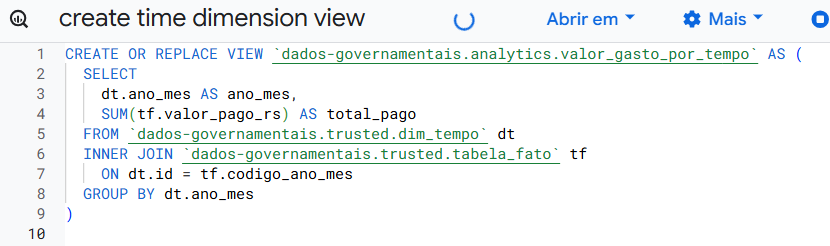

In [ ]:
from IPython.display import display, Image

display(Image('https://raw.githubusercontent.com/vitorwogel/MVP---Engenharia-de-Dados/main/images/view04.png'))

# Abaixo a consulta da view "programas_mais_onerados"

In [ ]:
# Define a query para buscar os dados da tabela
query = f"""
    SELECT *
    FROM `dados-governamentais.analytics.valor_gasto_por_tempo`
"""

# Executa a query e traz os dados como DataFrame
df_tempo = client.query(query).to_dataframe()

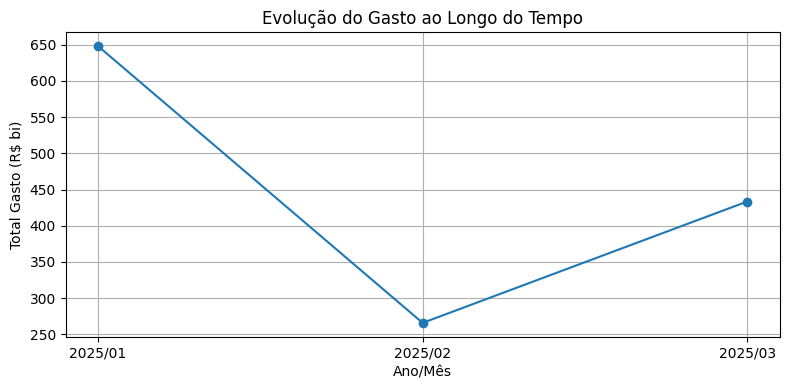

In [ ]:
# Plotar gráfico de linha
plt.figure(figsize=(8, 4))
plt.plot(df_tempo["ano_mes"], df_tempo["total_pago"] / 1e9, marker='o', linestyle='-')
plt.title("Evolução do Gasto ao Longo do Tempo")
plt.xlabel("Ano/Mês")
plt.ylabel("Total Gasto (R$ bi)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Análise**: O gasto do mês de fevereiro foi menos da metade do que foi gasto em Janeiro, embora tenha aumentado novamente em Março

In [ ]:
total_gasto = df_tempo["total_pago"].sum()
print(f"No primeiro trimestre de 2025 o governo federal gastou ao todo: R$ {total_gasto / 1e12:,.2f} trilhão de reais")

No primeiro trimestre de 2025 o governo federal gastou ao todo: R$ 1.35 trilhão de reais


**Conclusão:** A análise dos gastos federais no primeiro trimestre de 2025 evidencia uma concentração extrema em áreas de natureza financeira, como Encargos Especiais e Previdência Social, que juntas ultrapassam 80% do total empenhado — restando uma fatia bastante reduzida para setores historicamente prioritários, como Educação e Saúde.

Além disso, observa-se que os órgãos que mais gastam — especialmente o Ministério da Fazenda e o Ministério da Previdência Social — canalizam suas verbas para essas mesmas categorias, reforçando um padrão de concentração orçamentária.

Programas sociais e ações voltadas para assistência também surgem com destaque, superando investimentos estruturantes em áreas como ciência, tecnologia e inovação. Em paralelo, órgãos menores apresentam foco total em uma única função, o que indica uma baixa diversidade de políticas públicas executadas por essas instituições.

Por fim, os dados temporais indicam variações no volume de gastos ao longo dos três meses analisados, sem um padrão claro de crescimento ou retração, o que sugere a necessidade de monitoramento contínuo para identificar tendências sazonais ou desvios na execução orçamentária.

# Autoavaliação

O objetivo definido no início do trabalho foi investigar como se distribuem os gastos do governo federal brasileiro no primeiro trimestre de 2025, identificando os setores mais onerados, os órgãos responsáveis por esses repasses e a evolução do volume de despesas ao longo do período. Com base nessas perguntas, todas as etapas seguintes foram conduzidas para permitir que essas respostas fossem obtidas com clareza.

A coleta dos dados foi feita diretamente do Portal da Transparência, utilizando arquivos públicos em CSV, referentes aos três primeiros meses de 2025. Esses dados foram carregados no Google Cloud Storage (Data Lake) e posteriormente no BigQuery (Data Warehouse), com as devidas etapas de transformação e modelagem aplicadas.

O modelo de dados adotado foi baseado em esquema estrela, com separação das entidades em dimensões e uma tabela fato contendo os valores pagos e as chaves necessárias para análise. Essa estrutura viabilizou a criação de views analíticas que responderam diretamente às perguntas propostas.

Durante a execução do trabalho, algumas dificuldades se destacaram: o volume de colunas irrelevantes no dataset exigiu um esforço maior de limpeza e padronização, além de ajustes de codificação para viabilizar a carga no BigQuery. A etapa de modelagem também demandou atenção especial para evitar sobreposição de atributos nas dimensões. Outro ponto desafiador foi manter a estrutura da pipeline clara e funcional dentro do notebook, sem comprometer a legibilidade do código.

Para trabalhos futuros, seria interessante expandir a análise para além de um único trimestre, comparando padrões de gastos ao longo de diferentes anos ou governos. Também é possível explorar métricas de eficiência e impacto social associadas aos programas que mais recebem recursos, conectando volume de gasto com indicadores de resultado.

Em resumo, os objetivos propostos inicialmente foram atingidos, e o pipeline desenvolvido fornece uma base sólida para desdobramentos mais avançados dentro do mesmo problema.